Big Data Programming

TEIL A - Auswahl und Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import time
import dask.dataframe as dd

In [2]:
#Datensatz laden
url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Auto.csv'
data = pd.read_csv(url)

In [ ]:
# Kurzer Überblick
print(data.head())
print(data.info())
print(data.describe())
print(len(data))
#auf leere Werte prüfen
print(data.isnull().sum())
#auf Duplikate checken
print(data.duplicated().sum())
#auf extreme Ausreßer prüfen
print(data.describe())

Es folgt eine Untersuchung der Verteilung der Zielvariable MPG und der wichtigsten Features

In [ ]:
# Verteilung Zielvariable
sns.histplot(data['mpg'], kde=True)
plt.title('Verteilung - Meilen pro Gallone')
plt.show()

# Verteilung Horsepower/PS
sns.histplot(data['horsepower'], kde=True)
plt.title('Verteilung - Horsepower/PS')
plt.show()

# Verteilung Gewicht
sns.histplot(data['weight'], kde=True)
plt.title('Verteilung - Fahrzeuggewicht in Pfund(lbs)')
plt.show()

# Verteilung Beschleunigung
sns.histplot(data['acceleration'], kde=True)
plt.title('Verteilung - Beschleunigung in Sekunden (bis 60 MpH)')
plt.show()

# Verteilung Hubraum
sns.histplot(data['displacement'], kde=True)
plt.title('Verteilung - Hubraum in Kubikzoll')
plt.show()

#Boxplots für alle Features zur besseren Sichtbarkeit von Ausreißern
for i in ['mpg', 'horsepower', 'weight', 'acceleration', 'displacement']:
    sns.boxplot(x=data[i])
    plt.title(f'Boxplot {i}')
    plt.show()

In [ ]:
#Korrelationen visualisieren 
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Korrelationsmatrix')
plt.show()

Einige Werte in ‚horsepower‘ liegen als Zeichen statt als numerischer Wert vor, weshalb dieses Feature hier nicht in der Korrelationsmatrix enthalten ist. 
Dies ist gut zu sehen im Bereich "Überblick" durch die Funktion data.info(). Hier ist zu sehen, dass horsepower als object angezeigt wird und nicht als z.B. float64 oder int64.
Die Bereinigung und Konvertierung der Spalte erfolgt im Teil B.“

In [ ]:
#Scatterplots zum Visualisieren von Zusammenhängen

#PS und MPG
sns.scatterplot(x='horsepower', y='mpg', data=data)
plt.title('PS vs Verbrauch')
plt.show()

#Fahrzeuggewicht und MPG
sns.scatterplot(x='weight', y='mpg', data=data)
plt.title('Gewicht vs Verbrauch')
plt.show()

#Beschleunigung und MPG
sns.scatterplot(x='acceleration', y='mpg', data=data)
plt.title('Beschleunigung vs Verbrauch')
plt.show()

#Hubraum und MPG
sns.scatterplot(x='displacement', y='mpg', data=data)
plt.title('Hubraum vs Verbrauch')
plt.show()

In [ ]:
#Visualisieren kategorischer Features

#Zylinder
data['cylinders'].value_counts().sort_index().plot(kind='bar')
plt.title('Verteilung der Zylinderzahlen')
plt.xlabel('Zylinder')
plt.ylabel('Anzahl')
plt.show()

#Umwandlung von Zahlen in Klartext, zur besseren Verarbeitung. Zahlenzuordnung von https://rdrr.io/cran/ISLR/man/Auto.html
#Featuredesign ist zwar erst für Teil B vorgesehen, hier aber vorgezogen.
data['origin'] = data['origin'].map({1: 'USA', 2: 'Europa', 3: 'Japan'})

#Herkunftsland
data['origin'].value_counts().sort_index().plot(kind='bar')
plt.title('Verteilung der Herkunft (origin)')
plt.xlabel('Herkunft')
plt.ylabel('Anzahl')
plt.show()

#Baujahr
data['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Verteilung der Baujahre')
plt.xlabel('Jahr')
plt.ylabel('Anzahl')
plt.show()

TEIL B - Feature Engineering und Preprocessing

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    object 
 8   name          392 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 30.6+ KB
None
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


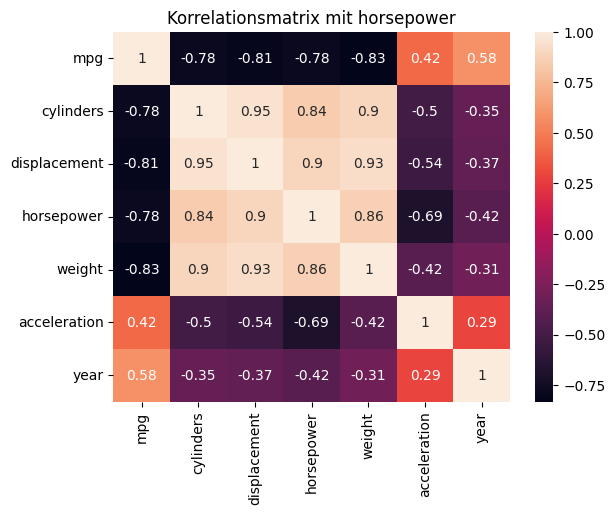

In [3]:
#Datenbereinigung

#horsepowerdaten in Zahlenwerte umwandeln, fehlende Werte auf NaN setzen
data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')

# Sicherheitshalber noch einmal die Umwandlung für 'origin':
data['origin'] = data['origin'].map({1: 'USA', 2: 'Europa', 3: 'Japan'})

#fehlende Werte entfernen, in bis dahin wichtigen Features
data = data.dropna(subset=['mpg', 'horsepower', 'origin'])

#nochmal auf fehlende Werte und Datentypen checken
print(data.info())
print(data.isnull().sum())

#nochmal Korrelationsheadmap erstellen für bessere Feature auswahl, da nun auch horsepower inbegriffen ist.
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True,)
plt.title('Korrelationsmatrix mit horsepower')
plt.show()

In [5]:
#Feature Engineering

#Für bessere Interpretation im internationalen Kontext, werden neue Spalten erstellt
#1. Gewicht in Kg
data['weight_kg'] = data['weight'] * 0.4536
#2. KW statt PS
data['power'] = data['horsepower'] * 0.7355
#3.Hubraum in Liter
data['displacement_liter'] = data['displacement'] * 0.0163871

#wichtige Features für das Modell auslagern
x = data[['power', 'year', 'acceleration', 'origin']]

#origin wird in Dummy-Variablen aufgeteilt, wobei ein Land weggelassen wird um Redundanz zu vermeiden.
#Die original Form (1,2,3) wird nicht verwendet um zu vermeiden, dass das Modell später Abstände der Zahlenwerte versucht zu interpretieren.
#Die Werte True/Flase werden in 1/0 unmgewandelt, da dies für ML besser geeignet ist.
x = pd.get_dummies(x, columns=['origin'], drop_first=True)
for i in ['origin_Japan', 'origin_USA']:
    x[i] = x[i].astype(int)

#erstellen eines Interaktionsterms aus Gewicht und Leistung
x['power_weight'] = data['power'] * data['weight_kg']

#Werte skalieren
scaler = StandardScaler()
x[['power', 'year', 'acceleration', 'power_weight']] = scaler.fit_transform(x[['power', 'year', 'acceleration', 'power_weight']])

#Kontrolle
print(x.head())

#Zielvariable erstellen
y = data['mpg']

      power      year  acceleration  origin_Japan  origin_USA  power_weight
0  0.664133 -1.625315     -1.285258             0           1      0.528582
1  1.574594 -1.625315     -1.466724             0           1      1.227955
2  1.184397 -1.625315     -1.648189             0           1      0.800830
3  1.184397 -1.625315     -1.285258             0           1      0.798784
4  0.924265 -1.625315     -1.829655             0           1      0.652885


TEIL C - Modellierung und Implementierung

14.982674596233391
3.011070303277925
0.7029198887532644


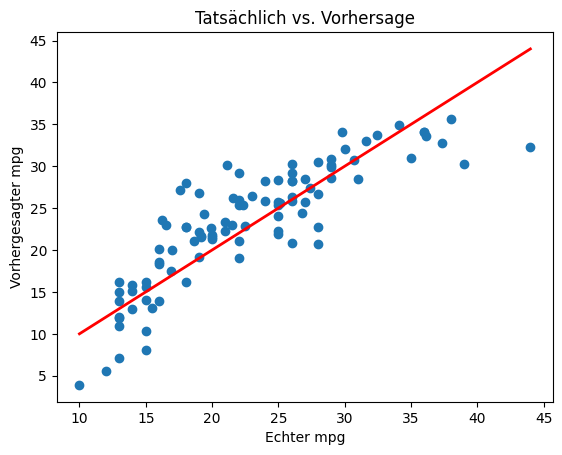

In [6]:
#Daten in Modelltrainings- und Modellvalidierungsdaten aufteilen
x_train, x_val, y_train, y_val = train_test_split(x,y,random_state=42)

#Modell - Lineare Regression trainieren
model = LinearRegression()
model.fit(x_train, y_train)

#Vorhersagedaten erstellen
y_forecast = model.predict(x_val)

#Bewertungsmetriken erstellen
mse = mean_squared_error(y_val, y_forecast)
mae = mean_absolute_error(y_val, y_forecast)
r2 = r2_score(y_val, y_forecast)

#Bewertungen ausgeben
print(mse)
print(mae)
print(r2)

#visuelle Ansicht
plt.scatter(y_val, y_forecast)
plt.xlabel("Echter mpg")
plt.ylabel("Vorhergesagter mpg")
plt.title("Tatsächlich vs. Vorhersage")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red", linewidth=2)  # Diagonale
plt.show()

einzel MAE [4.52424549 2.71794273 2.73920755 3.74451317 4.47393982]
Durchschnitt MAE 3.6399697526022834
R2 Einzelwerte [0.06252057 0.6519835  0.66781375 0.56330336 0.04923357]
Durchschnitt R2 0.3989709515120997


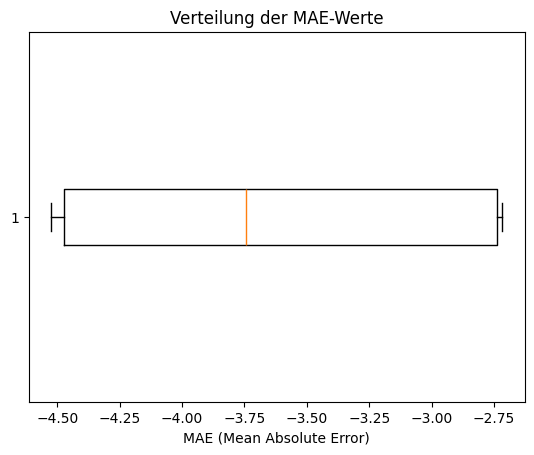

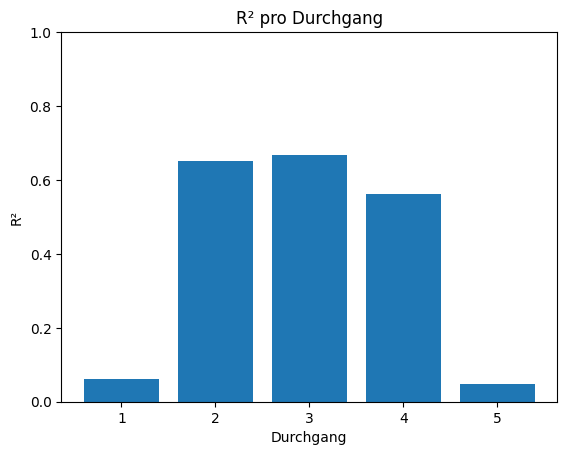

In [7]:
#Kreuzvalidierung für bessere Aussagekraft zum Modell

scores_mae = cross_val_score(model, x, y, cv=5, scoring='neg_mean_absolute_error')
print("einzel MAE",-scores_mae)
print("Durchschnitt MAE",-np.mean(scores_mae))

scores_r2 = cross_val_score(model, x, y, cv=5, scoring='r2')
print("R2 Einzelwerte", scores_r2)
print("Durchschnitt R2", np.mean(scores_r2))

#Visualisierung MAE als Boxplot
plt.boxplot(scores_mae, vert=False)
plt.xlabel("MAE (Mean Absolute Error)")
plt.title("Verteilung der MAE-Werte")
plt.show()
#Je schmaler die Box, desto stabiler ist das Modell; breite Box = große Streuung, also wenig robust.

#Visualisierung R2 als Balkendiagramm
plt.bar(range(1, 6), scores_r2)
plt.xlabel("Durchgang")
plt.ylabel("R²")
plt.title("R² pro Durchgang")
plt.ylim(0, 1)
plt.show()

2.882989624601697
3.806324977009076
0.7615625924371853


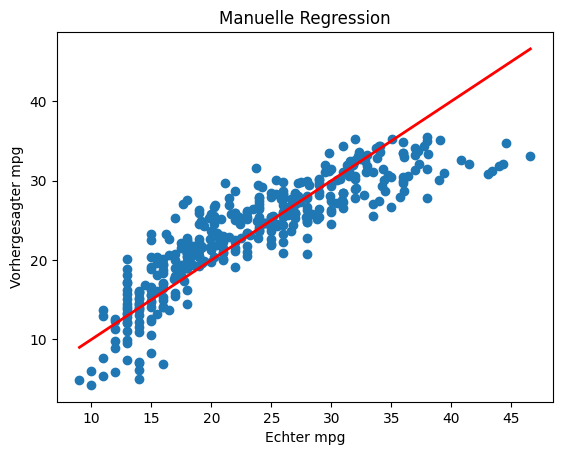

In [8]:
#eigene Implementierung mit Least Squares

#Bias-Spalte erstellen
x_b = np.c_[np.ones((x.shape[0], 1)), x]

#Koeffizienten berechnen
theta = np.linalg.inv(x_b.T @ x_b) @ x_b.T @ y

#Vorhersage
y_forecast_manual = x_b @ theta

#Werte berechnen
mae_manual = mean_absolute_error(y, y_forecast_manual)
rmse_manual = np.sqrt(mean_squared_error(y, y_forecast_manual))
r2_manual = r2_score(y, y_forecast_manual)

print(mae_manual)
print(rmse_manual)
print(r2_manual)

#Visualisierung mit Scatterplot
plt.scatter(y, y_forecast_manual)
plt.xlabel("Echter mpg")
plt.ylabel("Vorhergesagter mpg")
plt.title("Manuelle Regression")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linewidth=2)  # Diagonale
plt.show()

TEIL D - Big Data Skalierung

In [9]:
#Daten multiplizieren um etwa 40.000 Zeilen zu erhalten
big_data = pd.concat([data]*100, ignore_index=True)

#Kontrolle
print(big_data.shape[0])
print(big_data.head())

39200
    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

  origin                       name  weight_kg     power  displacement_liter  
0    USA  chevrolet chevelle malibu  1589.4144   95.6150            5.030840  
1    USA          buick skylark 320  1675.1448  121.3575            5.735485  
2    USA         plymouth satellite  1558.5696  110.3250            5.211098  
3    USA              amc rebel sst  1557.2088  110.3250            4.981678  
4    USA                ford torino  1564.4664  102.9700            4.948904  


In [ ]:
#Performance testen

#Mittelwert MpG Big Data
start = time.time()
big_mean_mpg = big_data['mpg'].mean()
print(big_mean_mpg)
print("Zeit:", round(time.time() - start, 4))

#Korrelation Big Data
start = time.time()
big_corr_val = big_data['mpg'].corr(big_data['power'])
print(big_corr_val)
print("Zeit:", round(time.time() - start, 4))

#Mittelwert MpG kleiner Datensatz
start = time.time()
mean_mpg = data['mpg'].mean()
print(mean_mpg)
print("Zeit:", round(time.time() - start, 4))

#Korrelation kleiner Datensatz
start = time.time()
corr_val = data['mpg'].corr(big_data['power'])
print(corr_val)
print("Zeit:", round(time.time() - start, 4))

In [ ]:
#Dask-Vergleich

#8 Partitionen erstellen
dask_value = dd.from_pandas(big_data, npartitions=8)

start = time.time()
mean_mpg_dask = dask_value['mpg'].mean().compute()
print(mean_mpg_dask)
print("Zeit:", round(time.time() - start, 4))

start = time.time()
corr_val_dask = dask_value['mpg'].corr(dask_value['power']).compute()
print(corr_val_dask)
print("Zeit:", round(time.time() - start, 4))